## Importing Libraries 

In [1]:
import os
os.environ['PYSPARK_DRIVER_PYTHON'] = '/opt/anaconda3/bin/python3.7'
os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python3.7'
os.environ["SPARK_HOME"] = '/opt/cloudera/parcels/CDH/lib/spark'

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession,SQLContext, Row
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col, log, isnan, count
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

cwd = os.getcwd() #Boiler
for part in cwd.split('/'):
    if part.lower().startswith('test6'):
        user_id = part.title()
    user_id = part.title().lower()

app_name = '{0} : Hive Integration'.format(user_id)
print("App Name - ",app_name)

sparkSession = (SparkSession.builder.appName("Data_Engineer_Capstone").config("hive.metastore.uris","thrift://ip-10-1-2-24.ap-south-1.compute.internal:9083").enableHiveSupport().getOrCreate())

print(sparkSession.sparkContext.getConf().getAll()) #configurations

App Name -  anabig11428 : Hive Integration
[('spark.eventLog.enabled', 'true'), ('spark.driver.extraLibraryPath', '/opt/cloudera/parcels/CDH-6.2.1-1.cdh6.2.1.p0.1425774/lib/hadoop/lib/native'), ('spark.driver.host', 'ip-10-1-1-204.ap-south-1.compute.internal'), ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'), ('spark.yarn.jars', 'local:/opt/cloudera/parcels/CDH-6.2.1-1.cdh6.2.1.p0.1425774/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.2.1-1.cdh6.2.1.p0.1425774/lib/spark/hive/*'), ('spark.sql.queryExecutionListeners', 'com.cloudera.spark.lineage.NavigatorQueryListener'), ('spark.driver.port', '35282'), ('spark.yarn.am.extraLibraryPath', '/opt/cloudera/parcels/CDH-6.2.1-1.cdh6.2.1.p0.1425774/lib/hadoop/lib/native'), ('spark.ui.killEnabled', 'true'), ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES', 'http://ip-10-1-1-204.ap-south-1.compute.internal:6066/proxy/application_1652166004796_5782'), ('spark.lineage.log.dir', '/var/log/spark/lineage')

create_tbl = "CREATE TABLE IF NOT EXISTS employees{}(age STRING, name STRING) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n'"
sparkSession.sql(create_tbl.format(user_id.upper()))


## Importing Data

In [2]:
sparkSession.sql('use db_vishvak').show()

++
||
++
++



In [3]:
sparkSession.sql('show tables').show()

+----------+--------------------+-----------+
|  database|           tableName|isTemporary|
+----------+--------------------+-----------+
|db_vishvak|              annual|      false|
|db_vishvak|       annual_return|      false|
|db_vishvak|           avg_itrst|      false|
|db_vishvak|         charged_off|      false|
|db_vishvak|                 clv|      false|
|db_vishvak|                cntr|      false|
|db_vishvak|   complex_data_type|      false|
|db_vishvak|             counter|      false|
|db_vishvak|         departments|      false|
|db_vishvak|            dept_emp|      false|
|db_vishvak|        dept_manager|      false|
|db_vishvak|         emp_details|      false|
|db_vishvak|emp_details_parti...|      false|
|db_vishvak|           employees|      false|
|db_vishvak|          hist_table|      false|
|db_vishvak|       interest_term|      false|
|db_vishvak|            kweblist|      false|
|db_vishvak|          kweblist_2|      false|
|db_vishvak|             latlong| 

In [4]:
sparkSession.sql("select * from departments").show()

+-------+------------------+
|dept_no|         dept_name|
+-------+------------------+
|   d001|         Marketing|
|   d002|           Finance|
|   d003|   Human Resources|
|   d004|        Production|
|   d005|       development|
|   d006|Quality Management|
|   d007|             Sales|
|   d008|          Research|
|   d009|  Customer Service|
+-------+------------------+



In [5]:
sparkSession.sql("select * from titles").show()

+--------+------------------+
|title_id|             title|
+--------+------------------+
|   e0001|Assistant Engineer|
|   e0002|          Engineer|
|   e0003|   Senior Engineer|
|   e0004|  Technique Leader|
|   m0001|           Manager|
|   s0001|             Staff|
|   s0002|      Senior Staff|
+--------+------------------+



# Spark EDA

## A list showing employee number, last name, first name, sex, and salary for each employee

In [6]:
sparkSession.sql("select s.emp_no, e.last_name, e.first_name, e.sex, s.salary from employees as e inner join salaries as s on s.emp_no = e.emp_no order by s.emp_no").show()


+------+-----------+----------+---+------+
|emp_no|  last_name|first_name|sex|salary|
+------+-----------+----------+---+------+
| 10001|    Facello|    Georgi|  M| 60117|
| 10002|     Simmel|   Bezalel|  F| 65828|
| 10003|    Bamford|     Parto|  M| 40006|
| 10004|    Koblick| Chirstian|  M| 40054|
| 10005|   Maliniak|   Kyoichi|  M| 78228|
| 10006|    Preusig|    Anneke|  F| 40000|
| 10007|  Zielinski|   Tzvetan|  F| 56724|
| 10008|   Kalloufi|    Saniya|  M| 46671|
| 10009|       Peac|    Sumant|  F| 60929|
| 10010|   Piveteau| Duangkaew|  F| 72488|
| 10011|      Sluis|      Mary|  F| 42365|
| 10012|  Bridgland|  Patricio|  M| 40000|
| 10013|     Terkki| Eberhardt|  M| 40000|
| 10014|      Genin|     Berni|  M| 46168|
| 10015|  Nooteboom|  Guoxiang|  M| 40000|
| 10016|Cappelletti|  Kazuhito|  M| 70889|
| 10017|  Bouloucos| Cristinel|  F| 71380|
| 10018|       Peha|  Kazuhide|  F| 55881|
| 10019|    Haddadi|   Lillian|  M| 44276|
| 10020|    Warwick|    Mayuko|  M| 40000|
+------+---

## A list showing first name, last  name, and hire date for employees who were hired in 1986


In [7]:
sparkSession.sql(" select emp_no, last_name, first_name, hire_date from employees where cast(substr( hire_date,7,4) as int) = 1986 ").show()

+------+---------+----------+----------+
|emp_no|last_name|first_name| hire_date|
+------+---------+----------+----------+
| 10081|    Rosen|  Zhongwei|10/30/1986|
| 10150|    Perng|  Zhenbing|11/16/1986|
| 10201|  Kavraki|     Idoia|11/22/1986|
| 10238|     Gire| Mototsugu|11/19/1986|
| 10268|   Siochi|    Nishit|12/17/1986|
| 10317|    Birge|      Arie|12/10/1986|
| 10361|    Sidou|     Seshu|10/23/1986|
| 10435| Tagansky|    Marsha|12/19/1986|
| 10522| Cesareni|     Marke|12/12/1986|
| 10533|Smailagic| Mohamadou|10/31/1986|
| 10701| Zolotykh| Hyuncheol|10/27/1986|
| 10807| Zallocco|  Munehiro|10/23/1986|
| 10832|  Bergere|     Hidde|10/11/1986|
| 10856|     Peck| Sreenivas|12/31/1986|
| 10962|   Kugler|    Naraig|12/16/1986|
| 10975| Birnbaum| Peternela|10/31/1986|
| 11010| Narwekar|    Jaques|12/18/1986|
| 11012|Speckmann|   Taegyun|12/28/1986|
| 11059|  Jarecki|    Shawna|11/17/1986|
| 11085|  Thummel|   Hailing|11/27/1986|
+------+---------+----------+----------+
only showing top


## A list showing the manager of each department with the following information: department number, department name, the manager's employee number, last name, first name.


In [8]:
sparkSession.sql("select distinct  dept_manager.dept_no, departments.dept_name, dept_manager.emp_no, employees.last_name, employees.first_name from dept_manager inner join departments on dept_manager.dept_no= departments.dept_no inner join employees on dept_manager.emp_no = employees.emp_no order by dept_manager.dept_no").show()


+-------+------------------+------+------------+-----------+
|dept_no|         dept_name|emp_no|   last_name| first_name|
+-------+------------------+------+------------+-----------+
|   d001|         Marketing|110022|  Markovitch|  Margareta|
|   d001|         Marketing|110039|    Minakawa|   Vishwani|
|   d002|           Finance|110114|  Legleitner|      Isamu|
|   d002|           Finance|110085|       Alpin|       Ebru|
|   d003|   Human Resources|110228|     Sigstam|    Karsten|
|   d003|   Human Resources|110183|Ossenbruggen|    Shirish|
|   d004|        Production|110344|       Cools|     Rosine|
|   d004|        Production|110303|     Wegerle|  Krassimir|
|   d004|        Production|110386|      Kieras|       Shem|
|   d004|        Production|110420|    Ghazalie|      Oscar|
|   d005|       development|110511|    Hagimont|   DeForest|
|   d005|       development|110567|    DasSarma|       Leon|
|   d006|Quality Management|110800|     Quadeer|     Sanjoy|
|   d006|Quality Managem

## A list showing the department of each employee with the following information: employee number, last name, first name, and department name

In [9]:
sparkSession.sql("select distinct  employees.emp_no, employees.last_name, employees.first_name, departments.dept_name from employees left join dept_emp on employees.emp_no = dept_emp.emp_no inner join departments on dept_emp.dept_no = departments.dept_no order by employees.emp_no").show()

+------+-----------+----------+------------------+
|emp_no|  last_name|first_name|         dept_name|
+------+-----------+----------+------------------+
| 10001|    Facello|    Georgi|       development|
| 10002|     Simmel|   Bezalel|             Sales|
| 10003|    Bamford|     Parto|        Production|
| 10004|    Koblick| Chirstian|        Production|
| 10005|   Maliniak|   Kyoichi|   Human Resources|
| 10006|    Preusig|    Anneke|       development|
| 10007|  Zielinski|   Tzvetan|          Research|
| 10008|   Kalloufi|    Saniya|       development|
| 10009|       Peac|    Sumant|Quality Management|
| 10010|   Piveteau| Duangkaew|        Production|
| 10010|   Piveteau| Duangkaew|Quality Management|
| 10011|      Sluis|      Mary|  Customer Service|
| 10012|  Bridgland|  Patricio|       development|
| 10013|     Terkki| Eberhardt|   Human Resources|
| 10014|      Genin|     Berni|       development|
| 10015|  Nooteboom|  Guoxiang|          Research|
| 10016|Cappelletti|  Kazuhito|

## A list showing first name, last name, and sex for employees whose first name is "Hercules" and last names begin with "B.“

In [10]:
sparkSession.sql("select last_name, first_name from employees where (first_name = 'Hercules') and (lower(last_name) like 'b%') order by last_name").show()


+-------------+----------+
|    last_name|first_name|
+-------------+----------+
|         Baak|  Hercules|
|         Baer|  Hercules|
|         Bahr|  Hercules|
|         Bail|  Hercules|
|         Bain|  Hercules|
|   Baranowski|  Hercules|
|     Barreiro|  Hercules|
|      Basagni|  Hercules|
|     Benantar|  Hercules|
|   Benzmuller|  Hercules|
|Bernardinello|  Hercules|
|    Bernatsky|  Hercules|
|      Berstel|  Hercules|
|        Biran|  Hercules|
|        Birge|  Hercules|
|        Biron|  Hercules|
|      Bisiani|  Hercules|
|       Bodoff|  Hercules|
|      Brendel|  Hercules|
|      Buchter|  Hercules|
+-------------+----------+



## A list showing all employees in the Sales department, including their employee number, last name, first name, and department name.

In [11]:
sparkSession.sql("select employees.emp_no, employees.last_name, employees.first_name, departments.dept_name from employees inner join dept_emp on dept_emp.emp_no = employees.emp_no inner join departments on dept_emp.dept_no= departments.dept_no where lower(departments.dept_name) = 'sales'").show()

+------+------------+----------+---------+
|emp_no|   last_name|first_name|dept_name|
+------+------------+----------+---------+
| 10002|      Simmel|   Bezalel|    Sales|
| 10016| Cappelletti|  Kazuhito|    Sales|
| 10034|        Swan|     Bader|    Sales|
| 10041|      Lenart|       Uri|    Sales|
| 10050|      Dredge|   Yinghua|    Sales|
| 10053|    Zschoche|    Sanjiv|    Sales|
| 10060| Billingsley|  Breannda|    Sales|
| 10061|      Herber|       Tse|    Sales|
| 10068|     Brattka|  Charlene|    Sales|
| 10087|     Eugenio|   Xinglin|    Sales|
| 10088|    Syrzycki|  Jungsoon|    Sales|
| 10089|Flasterstein| Sudharsan|    Sales|
| 10093|     Desikan|   Sailaja|    Sales|
| 10095|      Morton|    Hilari|    Sales|
| 10099|     Sullins|    Valter|    Sales|
| 10101|      Heyers|     Perla|    Sales|
| 10107|        Baca|      Dung|    Sales|
| 10125|     Hiltgen|     Syozo|    Sales|
| 10136|    Pintelas|    Zissis|    Sales|
| 10148|       Azumi|    Douadi|    Sales|
+------+---

## A list showing all employees in the Sales and Development departments, including their employee number, last name, first name, and department name.

In [12]:
sparkSession.sql("select employees.emp_no, employees.last_name, employees.first_name, departments.dept_name from employees inner join dept_emp on dept_emp.emp_no = employees.emp_no inner join departments on dept_emp.dept_no= departments.dept_no where (lower(departments.dept_name) = 'sales') or (lower(departments.dept_name) = 'development')").show()


+------+-----------+----------+-----------+
|emp_no|  last_name|first_name|  dept_name|
+------+-----------+----------+-----------+
| 10001|    Facello|    Georgi|development|
| 10002|     Simmel|   Bezalel|      Sales|
| 10006|    Preusig|    Anneke|development|
| 10008|   Kalloufi|    Saniya|development|
| 10012|  Bridgland|  Patricio|development|
| 10014|      Genin|     Berni|development|
| 10016|Cappelletti|  Kazuhito|      Sales|
| 10018|       Peha|  Kazuhide|development|
| 10021|       Erde|     Ramzi|development|
| 10022|     Famili|    Shahaf|development|
| 10023| Montemayor|     Bojan|development|
| 10025|     Heyers| Prasadram|development|
| 10027|    Reistad|    Divier|development|
| 10028|   Tempesti|  Domenick|development|
| 10031|     Joslin|   Karsten|development|
| 10034|       Swan|     Bader|      Sales|
| 10037|   Makrucki|   Pradeep|development|
| 10040|    Meriste|     Weiyi|development|
| 10041|     Lenart|       Uri|      Sales|
| 10043|    Tzvieli|    Yishay|d

## A list showing the frequency count of employee last names, in descending order. ( i.e., how many employees share each last name).

In [13]:
sparkSession.sql("select last_name,count(last_name) as Frequency from employees group by last_name order by Frequency desc").show()

+-----------+---------+
|  last_name|Frequency|
+-----------+---------+
|       Baba|      226|
|     Gelosh|      223|
|      Coorg|      223|
|     Farris|      222|
|    Sudbeck|      222|
|     Adachi|      221|
|     Osgood|      220|
|     Masada|      218|
|     Neiman|      218|
|    Mandell|      218|
|    Wendorf|      217|
|Boudaillier|      217|
|     Pettis|      216|
|     Mahnke|      216|
|    Solares|      216|
|   Cummings|      216|
|   Collette|      215|
|     Emmart|      215|
|   Birjandi|      215|
|    Kulisch|      215|
+-----------+---------+
only showing top 20 rows



## Histogram to show the salary distribution among employees.

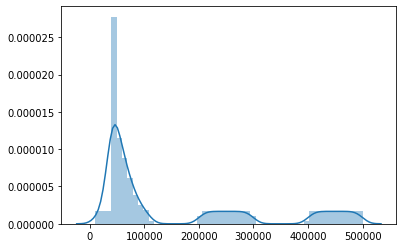

In [34]:
sns.distplot(sparkSession.sql("select emp_no, salary from salaries").toPandas())
plt.show()

In [15]:
sparkSession.sql("select * from employees limit 5").show()
sparkSession.sql("select * from salaries limit 5").show()
sparkSession.sql("select * from departments limit 5").show()
sparkSession.sql("select * from titles limit 5").show()
sparkSession.sql("select * from dept_emp limit 5").show()

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----------+----------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_status| last_date|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----------+----------+
| 10001|       e0003|  9/2/1953|    Georgi|  Facello|  M| 6/26/1986|             9|                      C|          1|7/30/1994
| 10002|       s0001|  6/2/1964|   Bezalel|   Simmel|  F|11/21/1985|             8|                      B|          0|         
| 10003|       e0003| 12/3/1959|     Parto|  Bamford|  M| 8/28/1986|             1|                      C|          0|         
| 10004|       e0003|  5/1/1954| Chirstian|  Koblick|  M| 12/1/1986|             5|                      A|          0|         
| 10005|       s0001| 1/21/1955|   Kyoichi| Maliniak|  M| 9/12/1989|             6|        

## Bar graph to show the Average Salary per title (designation)

In [16]:
Avg_Salary = sparkSession.sql("select round(avg(salaries.salary),2) as Avgsalary, titles.title from employees inner join salaries on salaries.emp_no = employees.emp_no inner join titles on employees.emp_title_id= titles.title_id group by titles.title order by Avgsalary").toPandas()

In [17]:
Avg_Salary

,Avgsalary,title
0,48506.80,Senior Engineer
1,48535.34,Engineer
2,48564.43,Assistant Engineer
3,48582.90,Technique Leader
4,51531.04,Manager
5,58465.38,Staff
6,58550.17,Senior Staff


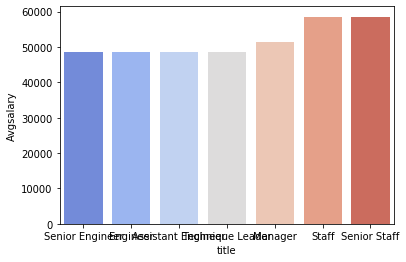

In [18]:
sns.barplot(x = Avg_Salary.title, y = Avg_Salary.Avgsalary, palette='coolwarm')
plt.show()

## Calculate employee tenure & show the tenure distribution among the employees.

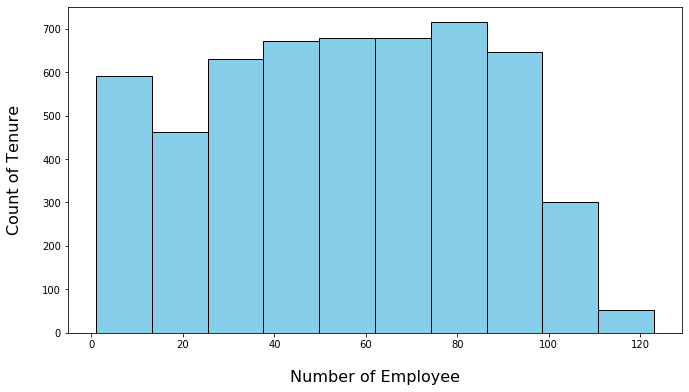

In [98]:
df = sparkSession.sql("select hire_date,replace(last_date,'\r','') as last_date from employees").toPandas()
df = pd.to_datetime(df['last_date'].replace("",max(df['hire_date']))) - pd.to_datetime(df['hire_date'])
df = df.value_counts()
plt.figure(figsize=(11,6))
plt.hist(df,color='skyblue',alpha=1,edgecolor='black')
plt.xlabel('Number of Employee',fontsize=16,color='black',labelpad=20)
plt.ylabel('Count of Tenure',fontsize=16,color='black',labelpad=20)
plt.show()

## How many employees are females and how many employees are male?

In [101]:
sparkSession.sql("select sex as Gender,count(sex) as No_of_Individuals from employees group by sex order by No_of_Individuals  desc").show()

+------+-----------------+
|Gender|No_of_Individuals|
+------+-----------------+
|     M|           179973|
|     F|           120051|
+------+-----------------+



## What is the average salary department wise?

In [102]:
sparkSession.sql("select departments.dept_name, avg(salaries.salary) as Avg_Salary from departments inner join dept_emp on departments.dept_no = dept_emp.dept_no inner join employees on dept_emp.emp_no = employees.emp_no inner join  salaries on employees.emp_no=salaries.emp_no group by departments.dept_name").show()

+------------------+------------------+
|         dept_name|        Avg_Salary|
+------------------+------------------+
|             Sales| 69832.12715092354|
|Quality Management| 46456.00571655814|
|           Finance| 59533.51654560129|
|        Production| 48760.45082669933|
|          Research|48850.189718829875|
|  Customer Service| 47998.67044105174|
|         Marketing| 61095.89738261343|
|       development|48697.334663446396|
|   Human Resources| 44678.64680085461|
+------------------+------------------+



## Average salary of Managers Departments wise.

In [106]:
sparkSession.sql("""select departments.dept_name, count(*) as Number_of_Managers_department_wise, round(avg(salaries.salary),0) Average_salary_of_managers from employees 
          join dept_manager on employees.emp_no = dept_manager.emp_no 
          join salaries on employees.emp_no = salaries.emp_no
          join departments on dept_manager.dept_no = departments.dept_no
          group by departments.dept_name""").show()

+------------------+----------------------------------+--------------------------+
|         dept_name|Number_of_Managers_department_wise|Average_salary_of_managers|
+------------------+----------------------------------+--------------------------+
|             Sales|                                 2|                   71380.0|
|Quality Management|                                 4|                   49260.0|
|           Finance|                                 2|                   56048.0|
|        Production|                                 4|                   43115.0|
|          Research|                                 2|                   60262.0|
|  Customer Service|                                 4|                   43462.0|
|         Marketing|                                 2|                   70554.0|
|       development|                                 2|                   44313.0|
|   Human Resources|                                 2|                   44146.0|
+---

## What is the average salary gender wise?

In [108]:
sparkSession.sql("""select employees.sex as Gender, avg(salaries.salary) as Avg_Salary
from employees inner join salaries
on employees.emp_no=salaries.emp_no
group by employees.sex""").show()

+------+------------------+
|Gender|        Avg_Salary|
+------+------------------+
|     F|  52953.8364278515|
|     M|52982.002944886175|
+------+------------------+



## Employees who are registered in more than one department

In [110]:
df = sparkSession.sql("select emp_no, count(emp_no) as frequency from dept_emp group by emp_no having count(emp_no) > 1 order by frequency desc")
print(f"There are {df.count()} who are registered in more than one department.")

There are 31579 who are registered in more than one department.


# Machine Learning

In [86]:
df = sparkSession.sql("select emp.*, salaries.salary, dpt.dept_name from employees as emp \
                inner join dept_emp on emp.emp_no = dept_emp.emp_no \
                inner join departments as dpt on dept_emp.dept_no = dpt.dept_no \
                inner join titles on emp.emp_title_id = titles.title_id \
                inner join salaries on emp.emp_no = salaries.emp_no").persist()
df.show(5)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----------+----------+------+---------------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_status| last_date|salary|      dept_name|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----------+----------+------+---------------+
| 60117|    development|
| 65828|          Sales|
| 40006|     Production|
| 40054|     Production|
| 78228|Human Resources|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----------+----------+------+---------------+
only showing top 5 rows



In [87]:
df = df.drop('emp_no', 'first_name', 'last_name', 'birth_date', 'emp_title_id', 'hire_date', 'last_date')
df.show(5)

+---+--------------+-----------------------+-----------+------+---------------+
|sex|no_of_projects|last_performance_rating|left_status|salary|      dept_name|
+---+--------------+-----------------------+-----------+------+---------------+
|  M|             9|                      C|          1| 60117|    development|
|  F|             8|                      B|          0| 65828|          Sales|
|  M|             1|                      C|          0| 40006|     Production|
|  M|             5|                      A|          0| 40054|     Production|
|  M|             6|                      A|          0| 78228|Human Resources|
+---+--------------+-----------------------+-----------+------+---------------+
only showing top 5 rows



## String Indexer 

In [88]:
df = StringIndexer(inputCol='sex', outputCol='Out_sex').fit(df).transform(df)
df = StringIndexer(inputCol='last_performance_rating', outputCol='Out_last_performance_rating').fit(df).transform(df)
df = StringIndexer(inputCol='dept_name', outputCol='Out_dept_name').fit(df).transform(df)

df.show(5)

+---+--------------+-----------------------+-----------+------+---------------+-------+---------------------------+-------------+
|sex|no_of_projects|last_performance_rating|left_status|salary|      dept_name|Out_sex|Out_last_performance_rating|Out_dept_name|
+---+--------------+-----------------------+-----------+------+---------------+-------+---------------------------+-------------+
|  M|             9|                      C|          1| 60117|    development|    0.0|                        2.0|          0.0|
|  F|             8|                      B|          0| 65828|          Sales|    1.0|                        0.0|          2.0|
|  M|             1|                      C|          0| 40006|     Production|    0.0|                        2.0|          1.0|
|  M|             5|                      A|          0| 40054|     Production|    0.0|                        1.0|          1.0|
|  M|             6|                      A|          0| 78228|Human Resources|    0.0|   

## Vector Assembler

In [89]:
# Fitting "Label" column

df = df.withColumnRenamed('left_status','label')
df.show(5)

+---+--------------+-----------------------+-----+------+---------------+-------+---------------------------+-------------+
|sex|no_of_projects|last_performance_rating|label|salary|      dept_name|Out_sex|Out_last_performance_rating|Out_dept_name|
+---+--------------+-----------------------+-----+------+---------------+-------+---------------------------+-------------+
|  M|             9|                      C|    1| 60117|    development|    0.0|                        2.0|          0.0|
|  F|             8|                      B|    0| 65828|          Sales|    1.0|                        0.0|          2.0|
|  M|             1|                      C|    0| 40006|     Production|    0.0|                        2.0|          1.0|
|  M|             5|                      A|    0| 40054|     Production|    0.0|                        1.0|          1.0|
|  M|             6|                      A|    0| 78228|Human Resources|    0.0|                        1.0|          7.0|
+---+---

In [90]:
df = VectorAssembler(inputCols = ['Out_sex', 'no_of_projects', 'Out_last_performance_rating', 'Out_dept_name', 'salary'], 
                                 outputCol = "features").transform(df).select('label','features')
df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.0,9.0,2.0,0.0,...|
|    0|[1.0,8.0,0.0,2.0,...|
|    0|[0.0,1.0,2.0,1.0,...|
|    0|[0.0,5.0,1.0,1.0,...|
|    0|[0.0,6.0,1.0,7.0,...|
|    0|[1.0,10.0,0.0,0.0...|
|    1|[1.0,6.0,0.0,4.0,...|
|    0|[0.0,9.0,2.0,0.0,...|
|    0|[1.0,8.0,0.0,6.0,...|
|    0|[1.0,4.0,1.0,6.0,...|
+-----+--------------------+
only showing top 10 rows



# Train Test Split

In [91]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed = 42)

# Model Building

In [92]:
rfm = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')
rfm = rfm.fit(train_df)

In [93]:
pred = rfm.transform(test_df)
pred.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],[1.0,400...|[45.0305413526121...|[0.90061082705224...|       0.0|
|    0|(5,[1,4],

In [94]:
def train(train, test, classifier):
    # (train, test) = df.randomSplit([.7,.3])
    print(classifier)
    model = classifier.fit(train)

    pred = model.transform(test)

    eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))

    eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))

    eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))

    eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

    accuracy = eval_accuracy.evaluate(pred)

    precision =  eval_precision.evaluate(pred)

    recall =  eval_recall.evaluate(pred)

    f1 =  eval_f1.evaluate(pred)

    print(f"""
    Accuracy  = {accuracy}
    Error     = {1-accuracy}
    Precision = {precision}
    Recall    = {recall}
    F1        = {f1}""")

    return model, pred

In [95]:
rfm2 = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

In [96]:
_ , pred2 = train(train_df, test_df, rfm2)

pred2.select("prediction", "label", "features").show(10)

RandomForestClassifier_6d3ffc8f03d9

    Accuracy  = 0.9002268488178656
    Error     = 0.09977315118213437
    Precision = 0.8104083793325443
    Recall    = 0.9002268488178656
    F1        = 0.8529596135710857
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
|       0.0|    0|(5,[1,4],[1.0,400...|
+----------+-----+--------------------+
only showing top 10 rows



<center><i><font color = 'purple'><font size = '5'> The model accuracy is 90%. Hence we shall finalise with RandomForest

# Building Pipline

## Preparing Data

In [80]:
# provide the tables
df2 = sparkSession.sql("select emp.*,salaries.salary, dpt.dept_name from employees as emp \
                inner join dept_emp on emp.emp_no = dept_emp.emp_no \
                inner join departments as dpt on dept_emp.dept_no = dpt.dept_no \
                inner join titles on emp.emp_title_id = titles.title_id \
                inner join salaries on emp.emp_no = salaries.emp_no").persist()

# dropping columns
df2 = df2.drop('emp_no', 'first_name', 'last_name', 'birth_date', 'emp_title_id', 'hire_date', 'last_date')

# Vector Assembler
Vect_InpCol = ['Out_sex', 'Out_last_performance_rating', 'Out_dept_name', 'salary']

# setting label column
df2 = df2.withColumnRenamed('left_status','label')

## Fixing Stages

In [81]:
# String Indexer
indexer_sex = StringIndexer(inputCol='sex', outputCol='Out_sex')
indexer_last_performance_rating = StringIndexer(inputCol='last_performance_rating', outputCol='Out_last_performance_rating')
indexer_dept_name = StringIndexer(inputCol='dept_name', outputCol='Out_dept_name')

# Vector Assembler
assembler = VectorAssembler(inputCols = Vect_InpCol, outputCol = "features")

# ML Model
rfm = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

# Creating Pipeline
pipeline = Pipeline(stages= [indexer_sex, indexer_last_performance_rating, indexer_dept_name, assembler, rfm])

## Train Test Split

In [82]:
train, test = df2.randomSplit([0.7, 0.3], seed = 42)

# Model Fitting

In [83]:
model = pipeline.fit(train)
y_pred_test = model.transform(test)
y_pred_test.select('label', 'features', 'prediction').show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
|    0|[1.0,1.0,3.0,4000...|       0.0|
+-----+--------------------+----------+
only showing top 10 rows

